# Pandemia de Covid-19 no Ceará: Podemos Começar a ter Esperança por Dias Melhores? As Previsões de Séries Temporais com Prophet nos ajudarão na resposta!

No momento que atingimos a triste marca de meio milhão de mortos pela Covid-19 só no Brasil, cabe a nós uma reflexão sobre esse cenário que estamos vivenciando. Cabe a nós buscar alguma "luz no fim do túnel", luz essa em formato de vacina e também de impeachment.

Nesse contexto, busco trazer uma breve análise sobre as curvas de novos casos e novos óbitos por Covid-19 no Ceará. Além disso, são trazidas previsões que podem nos ajudar a entender para onde esses números estão tendendo. Números não, vidas!


**Ciência de Dados na Pandemia de Covid-19 no Ceará?!**

Em 2020 e em 2021 a [Secretaria de Saúde do Estado do Ceará](https://www.saude.ce.gov.br/) realizou diversas ações convidando a própria comunidade de ciência de dados a ajudar nos esforços contra a doença, fornecendo análises e previsões acerca dos dados abertos fornecidos pelo próprio SUS.

<p align = "center">
    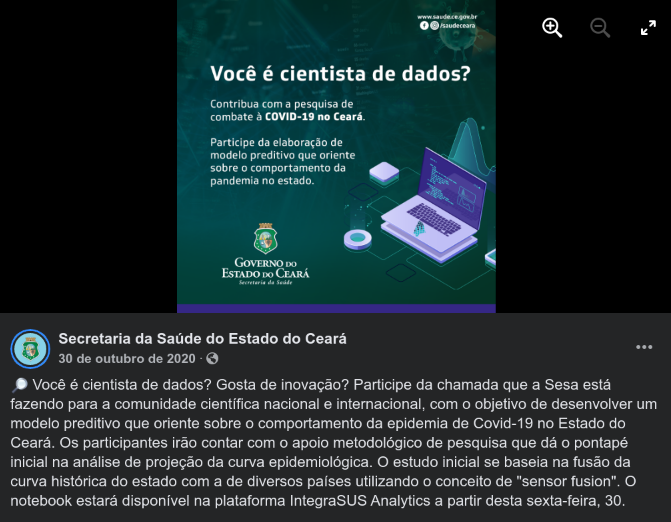
</p>


**Acima:** _Chamado da Secretária de Saúde do Ceará para o concurso de Ciência de Dados para prever os casos de Covid-19_

Esse concurso é bem explicado no link a seguir. Vale a pena a leitura, pois também fornece um enorme contexto para o uso de ciência de dados na saúde.

- [Sesa busca propostas de ferramentas para prever curva da Covid-19](https://diariodonordeste.verdesmares.com.br/metro/sesa-busca-propostas-de-ferramentas-para-prever-curva-da-covid-19-1.3009707)

Com isso também foi lançado o [IntegraSUS Analytics](https://integrasusanalytics.saude.ce.gov.br/pt/home), plataforma do Governo do Ceará de Ciência de Dados relacionada à Covid-19.

- [Secretaria da Saúde do Ceará lança plataforma de dados IntegraSUS Analytics](http://www.issec.ce.gov.br/index.php/assessoria-de-comunicacao/listanoticias/932-secretaria-da-saude-do-ceara-lanca-plataforma-de-dados-integrasus-analytics)

# Dados

Nesse projeto foram obtidos os dados de casos e óbitos por Covid-19 no Ceará no site do [Brasil.io](https://brasil.io/home/), um excelente repositório de dados públicos do nosso país.

Foi selecionado o dataset principal sobre a doença, disponível em: [Covid-19 - Brasil.io](https://brasil.io/dataset/covid19/caso_full/)

O próprio site nos diz que:

> Essa tabela possui os casos confirmados e óbitos obtidos dos boletins das Secretarias Estaduais de Saúde (SES). Os dados foram enriquecidos, de forma que a partir do momento em que um município confirma um caso, ele sempre aparecerá nessa tabela (mesmo que para uma determinada data a SES não tenha liberado o boletim - nesse caso é repetido o dado do dia anterior). Caso queira ver a tabela original (sem repetição e com datas faltantes), visite [caso](https://brasil.io/dataset/covid19/caso/).

O dataset utilizado nesse notebook possui sua última atualização no dia **29/06/2021** e uma cópia desse dataset encontra-se no [repositório do projeto](https://github.com/diascarolina/projeto-series-temporais-covid/blob/main/data/caso_full.csv.gz).

<div class="alert alert-success">
    <strong><a href='https://github.com/diascarolina/projeto-series-temporais-covid/blob/main/notebooks/limpeza-dados.ipynb'>Notebook de Limpeza dos Dados Sobre a Covid-19</a></strong>
</div>


Também foi feita uma breve análise sobre a vacinação contra a doença. Os dados foram extraídos de:

- [OpenDataSUS: Registros de Vacinação COVID-19](https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao/resource/ef3bd0b8-b605-474b-9ae5-c97390c197a8)

Como os dados são sobre cada aplicação individual da vacina, os arquivos são muito grandes. Por isso, adaptei os datasets para termos os dados da contagem de quantas doses de vacina foram aplicadas por dia, obtendo assim um arquivo bem menor que pode ser encontrado [aqui](https://github.com/diascarolina/projeto-series-temporais-covid/blob/main/data/vacina_total_ce.csv). Última atualização desses dados: **29/06/2021**.

# Bibliotecas & Configurações

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

In [2]:
# formatar os números para mostrarem duas casa decimais
pd.options.display.float_format = '{:.2f}'.format

# configurações de cores
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1 = '#F79747'

# configurações da fonte utilizada nos gráficos
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.bf'] = 'Arial:bold'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (15, 8)

In [3]:
feriados_ce_2020 = [
    '2020-01-01', # confraternização universal
    '2020-02-24', # carnaval
    '2020-02-25', # carnaval
    '2020-03-19', # Dia de São José
    '2020-03-25', # Data Magna
    '2020-04-10', # Sexta-Feira Santa
    '2020-04-21', # Tiradentes
    '2020-05-01', # dia do trabalho
    '2020-06-11', # corpus christi
    '2020-09-07', # dia da independência
    '2020-10-12', # dia de nossa senhora aparecida
    '2020-11-02', # dia de finados
    '2020-11-15', # proclamação da república
    '2020-12-25' # natal
]

feriados_ce_2021 = [
    '2021-01-01', # confraternização universal
    '2021-02-16', # carnaval
    '2021-03-19', # Dia de São José
    '2021-03-25', # Data Magna
    '2021-04-02', # Sexta-Feira Santa
    '2021-04-21', # Tiradentes
    '2021-05-01', # dia do trabalho
    '2021-06-03', # corpus christi
    '2021-09-07', # dia da independência
    '2021-10-12', # dia de nossa senhora aparecida
    '2021-11-02', # dia de finados
    '2021-11-15', # proclamação da república
    '2021-12-25' # natal
]

In [4]:
feriados_ce_2020 = pd.DataFrame({'holiday': 'ce_2020',
                                 'ds': pd.to_datetime(feriados_ce_2020)})

feriados_ce_2021 = pd.DataFrame({'holiday': 'ce_2021',
                                 'ds': pd.to_datetime(feriados_ce_2021)})

feriados = pd.concat((feriados_ce_2020, feriados_ce_2021))

# Análises

O escopo desse projeto é limitado. Tratarei apenas dos dados sobre a Covid no Estado do Ceará, sem entrar em nenhum município específico. Buscamos analisar como anda o crescimento da doença no Estado desde o primeiro caso registrado e tentar obter previsões para as séries temporais de casos e óbitos utilizando a Biblioteca Prophet.

Prophet é uma poderosa biblioteca de previsão de séries temporais criada pelo time de Ciência de Dados do Facebook. Presente em Python e em R, essa biblioteca trabalha muito bem (e rapidamente) com séries temporais com muita sazonalidade (como é o nosso caso). Além disso, existe a possibilidade de utilizá-lo para séries temporais multivariadas.

Ademais, faremos uma breve análise sobre a aplicação de vacinas contra a Covid-19 no Estado do Ceará.

In [5]:
# importação dos dados já limpos
covid_ce = pd.read_csv('../data/dados_covid_ce.csv')

In [6]:
# rápida conferida nos dados
covid_ce.head()

,data,novos_casos,novos_obitos,total_casos,total_mortes,semana_epidemiologica,pop_estimada_2019
0,2020-03-16,9,0,9,0,202012,9132078.00
1,2020-03-17,1,0,10,0,202012,9132078.00
2,2020-03-18,9,0,19,0,202012,9132078.00
3,2020-03-19,5,0,24,0,202012,9132078.00
4,2020-03-20,44,0,68,0,202012,9132078.00


In [7]:
# transformando a data para o modelo datetime
covid_ce['data'] = pd.to_datetime(covid_ce['data'], format = '%Y-%m-%d')

In [8]:
# colocando a data como índice do dataframe
covid_ce = covid_ce.set_index('data').rename_axis(None)

Vamos analisar graficamente os dados sobre os novos casos e novos óbitos por Covid-19.

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


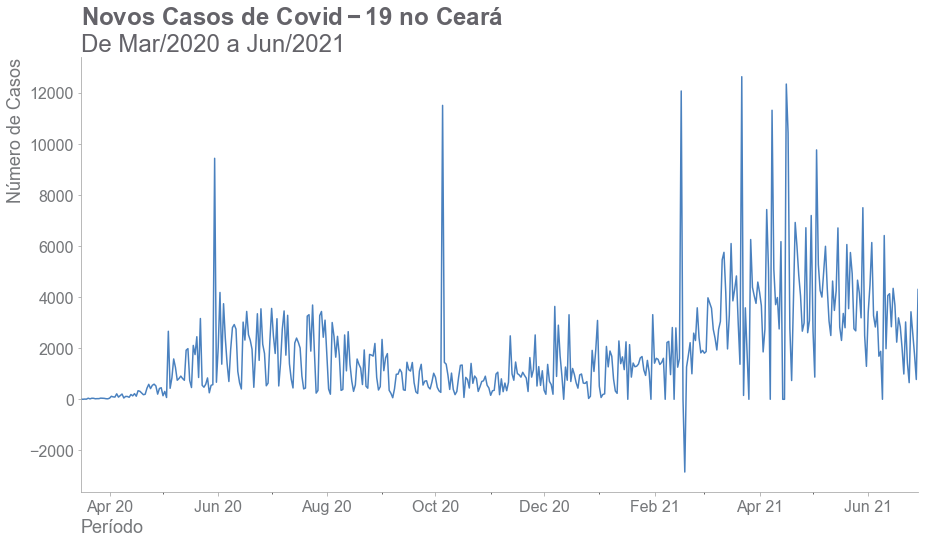

In [9]:
# plotagem dos novos casos de covid-19
ax = covid_ce.novos_casos.plot(color = BLUE2)
plt.title('$\\bf{Novos\ Casos\ de\ Covid-19\ no\ Ceará}$\nDe Mar/2020 a Jun/2021',
         fontsize = 24, loc = 'left', color = GRAY4)
ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
sns.despine()

# intervalo dos ticks do eixo x
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
# formata a data: %b - sigla do mês, %y - dois últimos dígitos do ano
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_color(GRAY5)

plt.ylabel('Número de Casos', loc = 'top', fontsize = 18, color = GRAY5)
plt.xlabel('Período', loc = 'left', fontsize = 18, color = GRAY5)

plt.show()

Essa série temporal está bastante poluída, até mesmo com valores abaixo de zero que podem representar correções nos dados. Uma melhor forma de visualizar isso seria com a média móvel.

In [10]:
# criando novas colunas no dataframe com a média móvel de novos casos e de novos óbitos
covid_ce['media_movel_casos'] = covid_ce['novos_casos'].rolling(window = 7, center = False).mean()
covid_ce['media_movel_obitos'] = covid_ce['novos_obitos'].rolling(window = 7, center = False).mean()

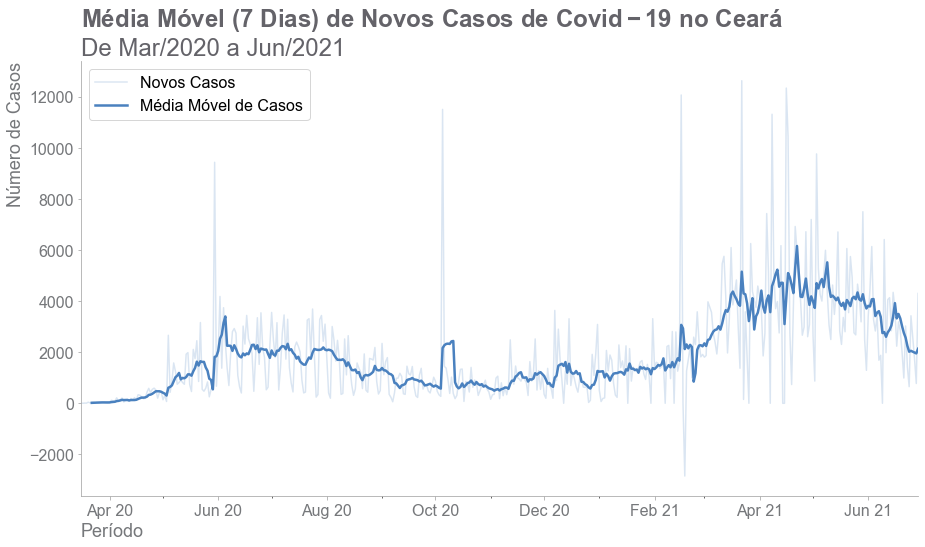

In [11]:
# plotagem da média móvel de novos casos de covid-19
ax = covid_ce['novos_casos'].plot(label = 'Novos Casos', alpha = 0.2, lw = 1.5, color = BLUE2)
covid_ce['media_movel_casos'].plot(label = 'Média Móvel de Casos', lw = 2.5, color = BLUE2)
plt.title('$\\bf{Média\ Móvel\ (7\ Dias)\ de\ Novos\ Casos\ de\ Covid-19\ no\ Ceará}$\nDe Mar/2020 a Jun/2021',
         fontsize = 24, loc = 'left', color = GRAY4)
ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
sns.despine()

# intervalo dos ticks do eixo x
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
# formata a data: %b - sigla do mês, %y - dois últimos dígitos do ano
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_color(GRAY5)

plt.ylabel('Número de Casos', loc = 'top', fontsize = 18, color = GRAY5)
plt.xlabel('Período', loc = 'left', fontsize = 18, color = GRAY5)

plt.legend()
plt.show()

Agora, ao utilizar a média móvel, temos uma série temporal bem mais comportada. Vamos olhar para o número de óbitos.

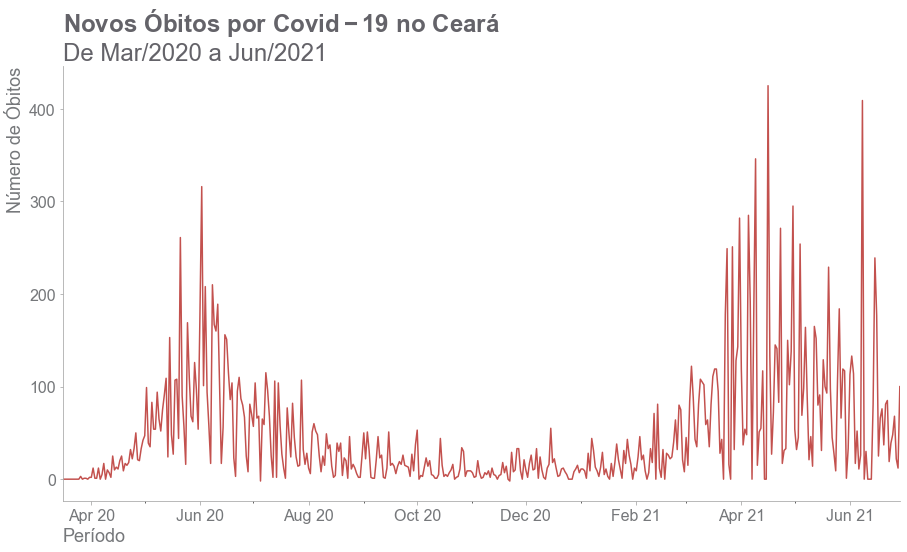

In [12]:
# plotagem dos novos óbitos por covid-19
ax = covid_ce.novos_obitos.plot(color = RED1)
plt.title('$\\bf{Novos\ Óbitos\ por\ Covid-19\ no\ Ceará}$\nDe Mar/2020 a Jun/2021',
         fontsize = 24, loc = 'left', color = GRAY4)
ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
sns.despine()

# intervalo dos ticks do eixo x
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
# formata a data: %b - sigla do mês, %y - dois últimos dígitos do ano
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_color(GRAY5)

plt.ylabel('Número de Óbitos', loc = 'top', fontsize = 18, color = GRAY5)
plt.xlabel('Período', loc = 'left', fontsize = 18, color = GRAY5)

plt.show()

Para o número de óbitos registrados diariamente não temos tantos valores abaixo de zero. Isso é de se esperar, pois o processo para registrar um óbito é bem mais complexo e burocrático, diminuindo a quantidade de erros inseridas no sistema.

Vamos agora olhar para a média móvel de novos óbitos.

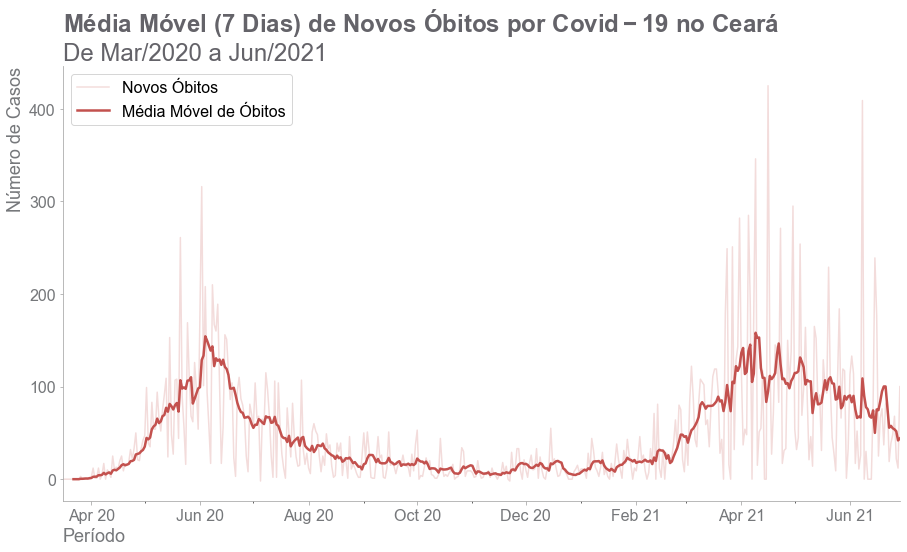

In [13]:
# plotagem da média móvel de novos óbitos por covid-19
ax = covid_ce['novos_obitos'].plot(label = 'Novos Óbitos', alpha = 0.2, lw = 1.5, color = RED1)
covid_ce['media_movel_obitos'].plot(label = 'Média Móvel de Óbitos', lw = 2.5, color = RED1)
plt.title('$\\bf{Média\ Móvel\ (7\ Dias)\ de\ Novos\ Óbitos\ por\ Covid-19\ no\ Ceará}$\nDe Mar/2020 a Jun/2021',
         fontsize = 24, loc = 'left', color = GRAY4)
ax.tick_params(color = 'darkgrey', bottom = 'off')
ax.spines['bottom'].set_color('darkgrey')
ax.spines['left'].set_color('darkgrey')
sns.despine()

# intervalo dos ticks do eixo x
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
# formata a data: %b - sigla do mês, %y - dois últimos dígitos do ano
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_color(GRAY5)

plt.ylabel('Número de Casos', loc = 'top', fontsize = 18, color = GRAY5)
plt.xlabel('Período', loc = 'left', fontsize = 18, color = GRAY5)

plt.legend()
plt.show()

Vamos comparar essas séries temporais.

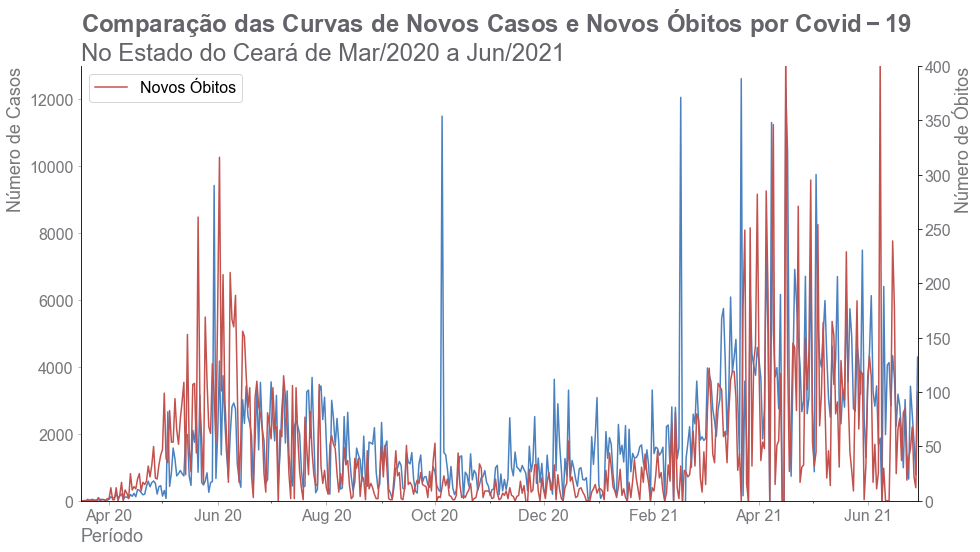

In [14]:
# plotagem das duas séries (novos casos e novos óbitos) para efeito de comparação dos picos
ax1 = covid_ce['novos_casos'].plot(label = 'Novos Casos', color = BLUE2)
ax2 = ax1.twinx()
ax2 = covid_ce['novos_obitos'].plot(label = 'Novos Óbitos', color = RED1)
plt.title('$\\bf{Comparação\ das\ Curvas\ de\ Novos\ Casos\ e\ Novos\ Óbitos\ por\ Covid-19}$\nNo Estado do Ceará de Mar/2020 a Jun/2021',
         fontsize = 24, loc = 'left', color = GRAY4)
ax1.tick_params(color = 'darkgrey', bottom = 'off')
ax1.spines['bottom'].set_color('darkgrey')
ax1.spines['left'].set_color('darkgrey')
ax1.spines['right'].set_color('darkgrey')
ax2.spines['top'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

for i in ax1.get_yticklabels() + ax1.get_xticklabels():
    i.set_color(GRAY5)
for i in ax2.get_yticklabels() + ax2.get_xticklabels():
    i.set_color(GRAY5)

ax1.set_ylabel('Número de Casos', loc = 'top', fontsize = 18, color = GRAY5)
ax1.set_xlabel('Período', loc = 'left', fontsize = 18, color = GRAY5)
ax2.set_ylabel('Número de Óbitos', loc = 'top', fontsize = 18, color = GRAY5)

ax1.set_ylim(0, 13000)
ax2.set_ylim(0, 400)

plt.legend()
plt.show()

Mesmo sendo uma visualização poluída, conseguimos enxergar algumas conclusões.

Diferentemente de alguns outros estados, aqui, aparentemente, as duas curvas estão bem próximas, com pouco ou quase nenhum delay entre o número de morte e de novos casos no Ceará.

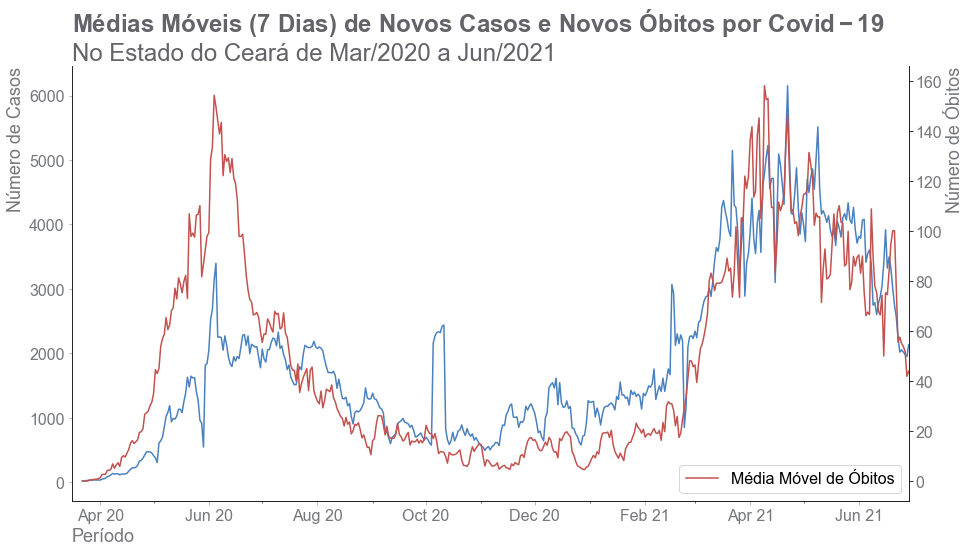

In [15]:
# plotagem das duas séries (média móvel de novos casos e de novos óbitos) para efeito de comparação dos picos
ax1 = covid_ce['media_movel_casos'].plot(label = 'Média Móvel de Casos', color = BLUE2)
ax2 = ax1.twinx()
ax2 = covid_ce['media_movel_obitos'].plot(label = 'Média Móvel de Óbitos', color = RED1)
plt.title('$\\bf{Médias\ Móveis\ (7\ Dias)\ de\ Novos\ Casos\ e\ Novos\ Óbitos\ por\ Covid-19}$\nNo Estado do Ceará de Mar/2020 a Jun/2021',
         fontsize = 24, loc = 'left', color = GRAY4)
ax1.tick_params(color = 'darkgrey', bottom = 'off')
ax1.spines['bottom'].set_color('darkgrey')
ax1.spines['left'].set_color('darkgrey')
ax1.spines['right'].set_color('darkgrey')
ax2.spines['top'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

for i in ax1.get_yticklabels() + ax1.get_xticklabels():
    i.set_color(GRAY5)
for i in ax2.get_yticklabels() + ax2.get_xticklabels():
    i.set_color(GRAY5)

ax1.set_ylabel('Número de Casos', loc = 'top', fontsize = 18, color = GRAY5)
ax1.set_xlabel('Período', loc = 'left', fontsize = 18, color = GRAY5)
ax2.set_ylabel('Número de Óbitos', loc = 'top', fontsize = 18, color = GRAY5)

plt.legend()
plt.show()

As curvas acompanham bem uma a outra.

/home/carolina/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/carolina/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


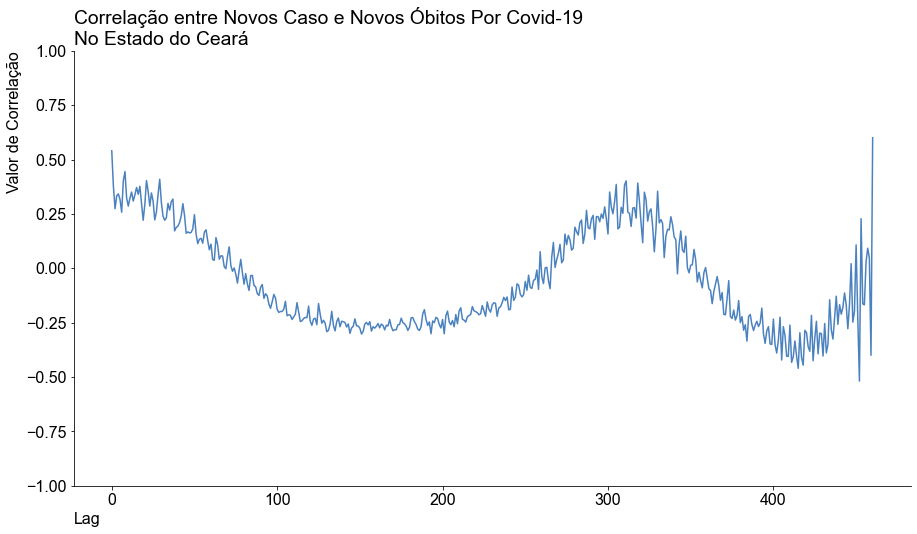

In [16]:
# correlação entre os novos casos e os novos óbitos
correlacao_obitos_casos = [covid_ce['novos_casos'].corr(covid_ce['novos_obitos'].shift(t)) for t in range(0, len(covid_ce))]
lag = range(0, len(covid_ce))
sns.lineplot(x = lag, y = correlacao_obitos_casos, color = BLUE2)
plt.ylim(-1, 1)
plt.title('Correlação entre Novos Caso e Novos Óbitos Por Covid-19\nNo Estado do Ceará', loc = 'left')
plt.xlabel('Lag', loc = 'left')
plt.ylabel('Valor de Correlação', loc = 'top')
sns.despine()
plt.show()

comentários sobre a correlação

# Previsões com o FBProphet

Para o número de novos casos e para o número de novos óbitos, temos séries temporais. Esse tipo especial de curva é caracterizado por ser baseado em períodos de tempo. Existem métodos especiais para tratar as séries temporais, como métodos específicos de previsão em Machine Learning (mas métodos tradicionais de regressão também podem ser utilizados, se forem adaptados).

O método específico que usaremos é o da biblioteca Prophet, desenvolvida pelo Facebook. Essa poderosa biblioteca auxilia na previsão e análise de séries temporais.

## Previsão de Novos Casos

Aqui, iremos utilizar o Prophet para realizar a previsão do número de novos casos de Covid-19. Vamos separar os dados que já temos em dados de treino e dados de teste e, após isso, tentar prever novos casos para os futuros próximos 30 dias.

**Separação em dados de treino e dados de teste:**

In [17]:
# criação de um novo dataframe (de treino) no modelo aceito pelo Prophet
df_treino = pd.DataFrame()
df_treino['y'] = covid_ce['novos_casos'][:400]
df_treino['ds'] = covid_ce.index[:400]
df_treino.index = range(0, 400)
df_treino

,y,ds
0,9,2020-03-16
1,1,2020-03-17
2,9,2020-03-18
3,5,2020-03-19
4,44,2020-03-20
...,...,...
395,0,2021-04-15
396,12331,2021-04-16
397,10423,2021-04-17
398,2775,2021-04-18


In [18]:
# criação de um novo dataframe (de teste) no modelo aceito pelo Prophet
df_teste = pd.DataFrame()
df_teste['y'] = covid_ce['novos_casos'][400:]
df_teste['ds'] = covid_ce.index[400:]
df_teste.index = range(0, len(covid_ce) - 400)
df_teste

,y,ds
0,3911,2021-04-20
1,6917,2021-04-21
2,5979,2021-04-22
3,4852,2021-04-23
4,4044,2021-04-24
...,...,...
66,3424,2021-06-25
67,2610,2021-06-26
68,1753,2021-06-27
69,775,2021-06-28


**Inicialização do Modelo de Previsão:**

Os hiperparâmetros utilizados abaixo foram obtidos após alguns testes com os dados para obtermos o melhor "fit" nos dados.

In [19]:
# inicialização do modelos com hiperparâmetros escolhidos após testagem com os dados
modelo = Prophet(n_changepoints = 25,
                 changepoint_prior_scale = 10.0,
                 seasonality_mode = 'multiplicative',
                 holidays = feriados,
                 weekly_seasonality = 7)

# fit do modelo nos dados de treino
modelo.fit(df_treino)

# previsão (que aqui, no caso, é para zero dias)
dataframefuturo = modelo.make_future_dataframe(periods = 0)
previsao = modelo.predict(dataframefuturo)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**Visualização Gráfica do Modelo Inicial:**

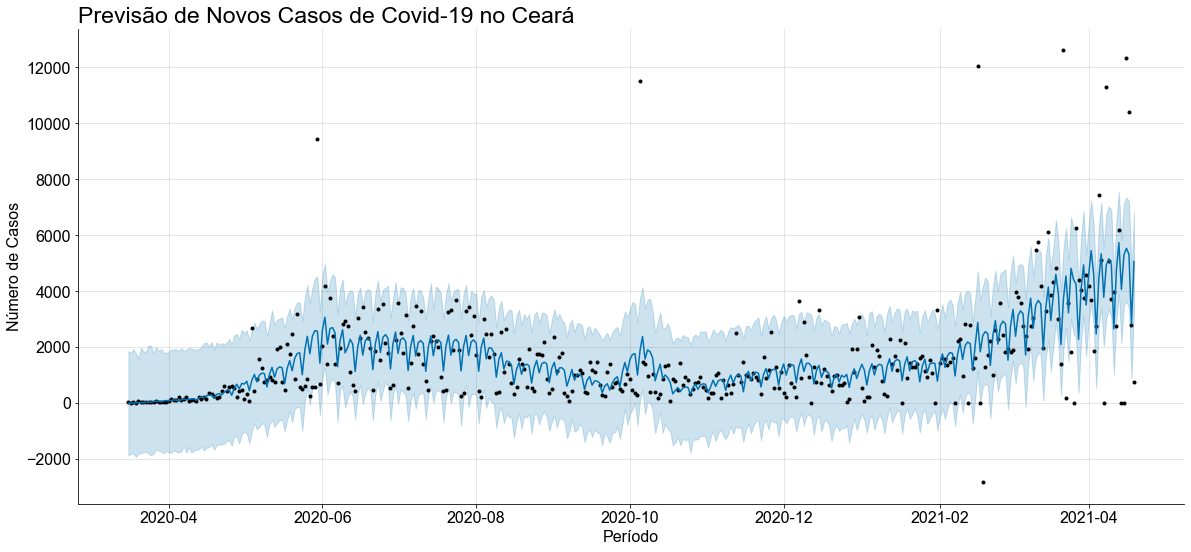

In [20]:
fig = modelo.plot(previsao, xlabel = 'Período', ylabel = 'Número de Casos')
ax = fig.gca()
fig.set_size_inches(18, 8)
plt.title('Previsão de Novos Casos de Covid-19 no Ceará', loc = 'left', fontsize = 23)
sns.despine()
plt.show()

O passo acima foi feito para termos alguns parâmetros para a eliminação de _outliers_, que faremos a seguir.

In [21]:
# noto dataframe
novo_y = df_treino.reset_index()

In [22]:
# dataframe sem ouliers, usamos comparação para encontrar os outliers
sem_outliers = novo_y[(novo_y['y'] > previsao['yhat_lower']) & (novo_y['y'] < previsao['yhat_upper'])]

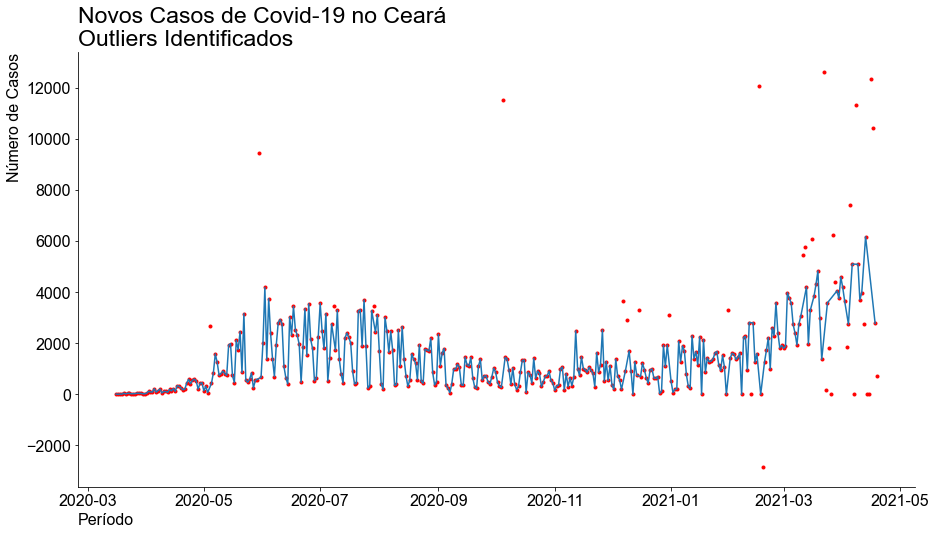

In [23]:
# plotagem da uma curva excluindo os outliers
plt.plot(df_treino['ds'], df_treino['y'], 'r.')
plt.plot(sem_outliers['ds'], sem_outliers['y'])

plt.title('Novos Casos de Covid-19 no Ceará\nOutliers Identificados', loc = 'left', fontsize = 23)
plt.xlabel('Período', loc = 'left')
plt.ylabel('Número de Casos', loc = 'top')
sns.despine()
plt.show()

In [24]:
# preparação do dataframe sem outliers
df_sem_outliers = sem_outliers[['ds','y']]

**Novo modelo, agora sem os outliers:**

Aqui iremos já fazer a previsão para os próximos 29 dias, além da previsão nos 71 dias dos dados de teste.

In [25]:
# inicialização do modelo
modelo = Prophet(n_changepoints = 25,
                 changepoint_prior_scale = 10.0,
                 seasonality_mode = 'multiplicative',
                 holidays = feriados,
                 weekly_seasonality = 7)

# fit do modelo nos dados de treino sem outliers
modelo.fit(df_sem_outliers)

# temos 71 dados de teste (71 dias)
# vamos adicionar mais 29 dias para servir como previsao futura
dataframefuturo = modelo.make_future_dataframe(periods = 100)
previsao = modelo.predict(dataframefuturo)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**Plotagem gráfica desse modelo sem outliers:**

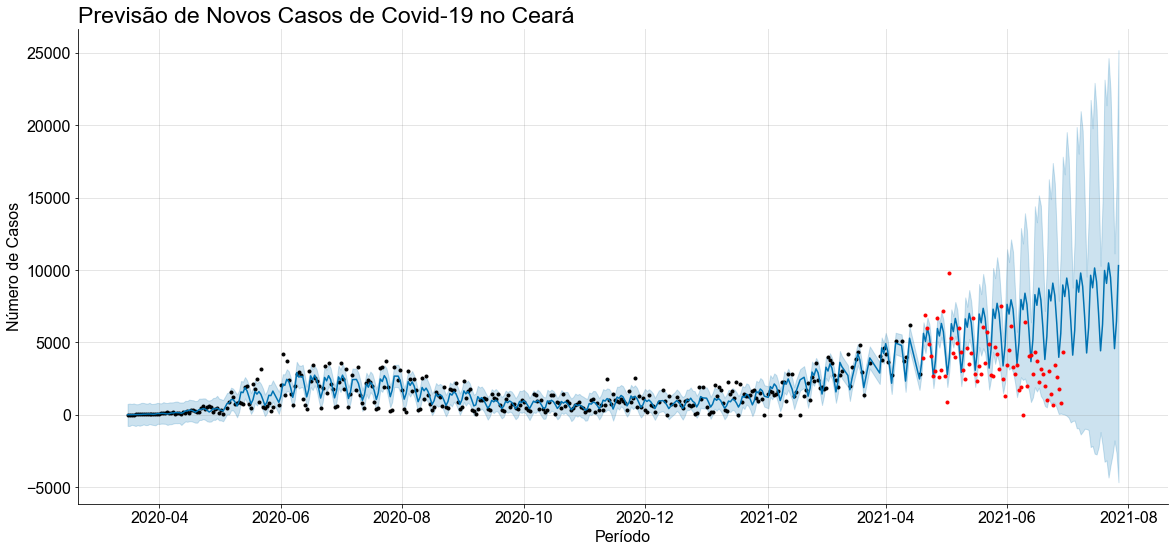

In [26]:
fig = modelo.plot(previsao, xlabel = 'Período', ylabel = 'Número de Casos')
plt.plot(df_teste['ds'], df_teste['y'], '.r')
ax = fig.gca()
fig.set_size_inches(18, 8)
plt.title('Previsão de Novos Casos de Covid-19 no Ceará', loc = 'left', fontsize = 23)
sns.despine()
plt.show()

**Plotagem dos Componentes da Séries Temporal de Novos Casos**

Separar a série temporal em componentes é importante para podermos analisar individualmente a tendência de crescimento ou decaimento da série, sua sazonalidade e também os ruído presente na série.

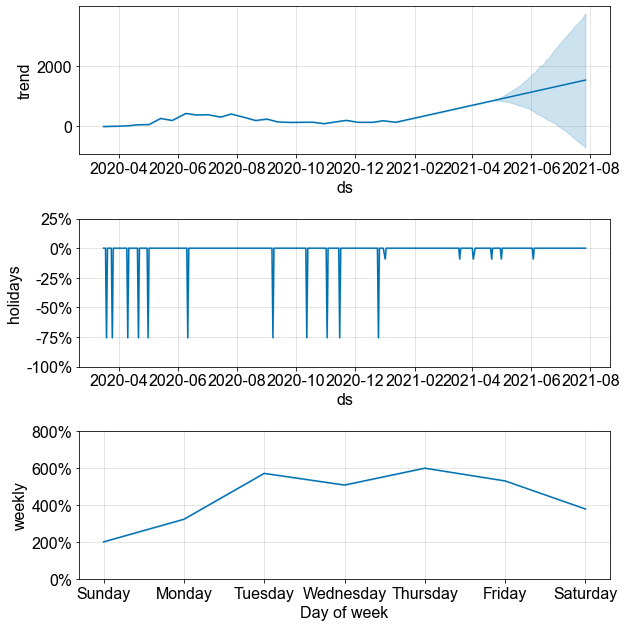

In [27]:
modelo.plot_components(previsao);

Abaixo vamos ver os possíveis cenários de previsão da tendência da série temporal.

In [28]:
amostras = modelo.predictive_samples(previsao)

[]

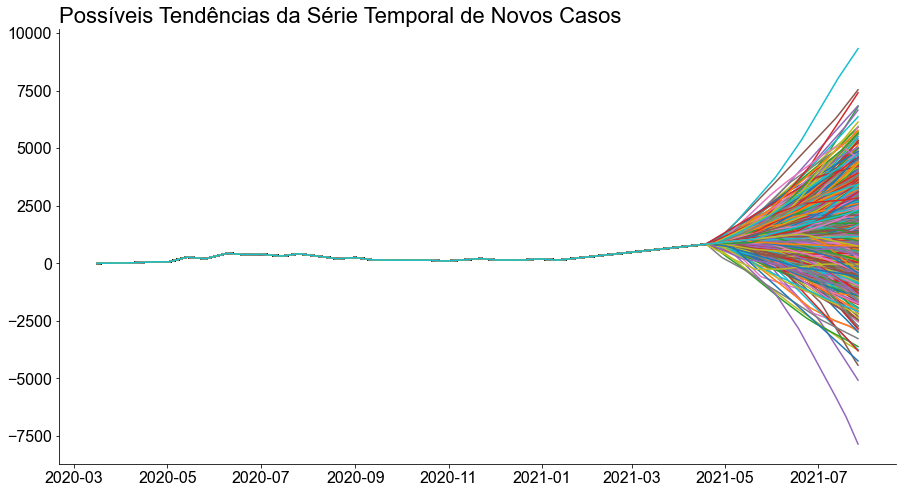

In [29]:
plt.plot(previsao['ds'], amostras['trend']);
plt.title('Possíveis Tendências da Série Temporal de Novos Casos', loc = 'left', fontsize = 22)
sns.despine()
plt.plot()

## Previsão de Novos Óbitos

Agora a previsão será do número de novos óbitos por Covid-19, novamente usando o Prophet. Faremos o mesmo método utilizado acima.

O Prophet possui um método bastante útil, o ```".add_regressor()"``` que permite que adicionemos um dados extra que ajude na previsão da série. Aqui nesse caso, de novos óbitos, podemos adicionar como regressor o número de novos casos de Covid-19, transformando assim o problema em um problema de previsão de séries multivariadas.

Isso é fácil de ser entendido pensando que ao passo que o número de casos aumentam, logo o número de óbitos também aumenta, infelizmente.

Tentei utilizar esse método na previsão abaixo, mas não funcionou bem. Creio que precisasse escalar as variáveis para ele funcionar melhor, mas não o fiz por falta de tempo. Deixo aqui o relato para próximos projetos.

**Separação em dados de treino e dados de teste:**

In [30]:
df_treino = pd.DataFrame()
df_treino['y'] = covid_ce['novos_obitos'][:400]
df_treino['ds'] = covid_ce.index[:400]
df_treino.index = range(0, 400)
df_treino

,y,ds
0,0,2020-03-16
1,0,2020-03-17
2,0,2020-03-18
3,0,2020-03-19
4,0,2020-03-20
...,...,...
395,0,2021-04-15
396,425,2021-04-16
397,133,2021-04-17
398,27,2021-04-18


In [31]:
df_teste = pd.DataFrame()
df_teste['y'] = covid_ce['novos_obitos'][400:]
df_teste['ds'] = covid_ce.index[400:]
df_teste.index = range(0, len(covid_ce) - 400)
df_teste

,y,ds
0,145,2021-04-20
1,141,2021-04-21
2,83,2021-04-22
3,271,2021-04-23
4,17,2021-04-24
...,...,...
66,48,2021-06-25
67,68,2021-06-26
68,22,2021-06-27
69,12,2021-06-28


**Inicialização do Modelo:**

Os hiperparâmetros utilizados foram os que melhor fizeram com que a curva aderisse aos dados.

In [32]:
modelo = Prophet(interval_width = 0.95,
                 n_changepoints = 25,
                 changepoint_prior_scale = 10.0,
                 seasonality_mode = 'multiplicative',
                 holidays = feriados,
                 weekly_seasonality = 7)

modelo.fit(df_treino)

dataframefuturo = modelo.make_future_dataframe(periods = 0)

previsao = modelo.predict(dataframefuturo)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**Plotagem gráfica do modelo anterior:**

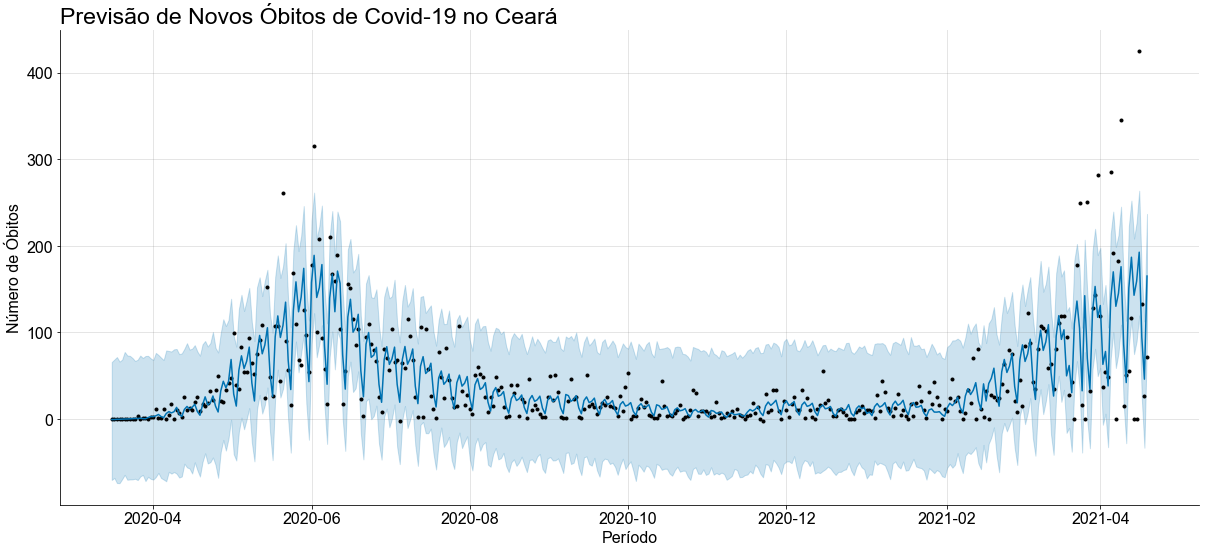

In [33]:
fig = modelo.plot(previsao, xlabel = 'Período', ylabel = 'Número de Óbitos')
ax = fig.gca()
fig.set_size_inches(18, 8)
plt.title('Previsão de Novos Óbitos de Covid-19 no Ceará', loc = 'left', fontsize = 23)
sns.despine()
plt.show()

**Remoção dos outliers:**

In [34]:
novo_y = df_treino.reset_index()

In [35]:
sem_outliers = novo_y[(novo_y['y'] > previsao['yhat_lower']) & (novo_y['y'] < previsao['yhat_upper'])]

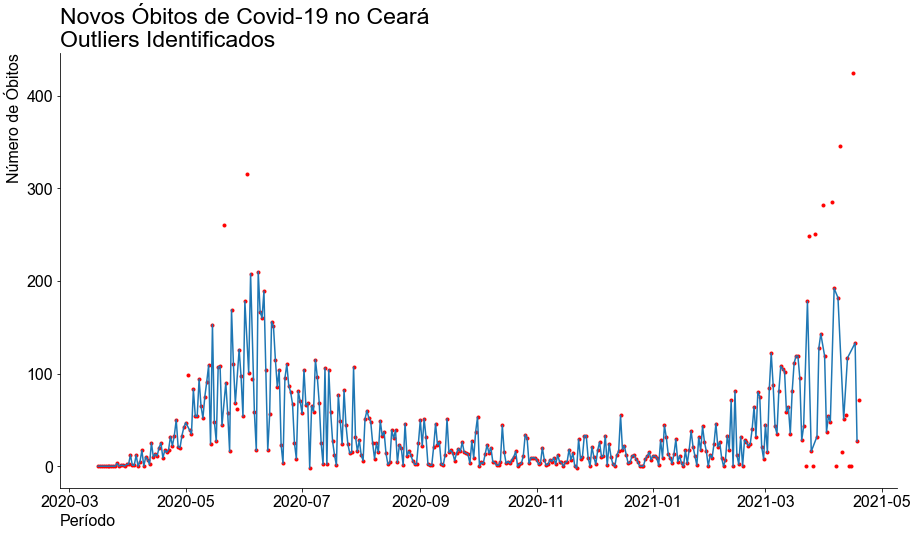

In [36]:
# plotagem da uma curva excluindo os outliers
plt.plot(df_treino['ds'], df_treino['y'], 'r.')
plt.plot(sem_outliers['ds'], sem_outliers['y'])

plt.title('Novos Óbitos de Covid-19 no Ceará\nOutliers Identificados', loc = 'left', fontsize = 23)
plt.xlabel('Período', loc = 'left')
plt.ylabel('Número de Óbitos', loc = 'top')
sns.despine()
plt.show()

In [37]:
df_sem_outliers = sem_outliers[['ds','y']]

**Modelo melhorado com a remoção dos outliers:**

Previsão nos 71 dados de teste mais 29 dias extras.

In [38]:
modelo = Prophet(n_changepoints = 25,
                 changepoint_prior_scale = 10.0,
                 seasonality_mode = 'multiplicative',
                 holidays = feriados,
                 weekly_seasonality = 7)

modelo.fit(df_sem_outliers)

# temos 71 dados de teste (71 dias)
# vamos adicionar mais 29 dias para servir como previsao futura
dataframefuturo = modelo.make_future_dataframe(periods = 100)
previsao = modelo.predict(dataframefuturo)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**Plotagem do modelo anterior:**

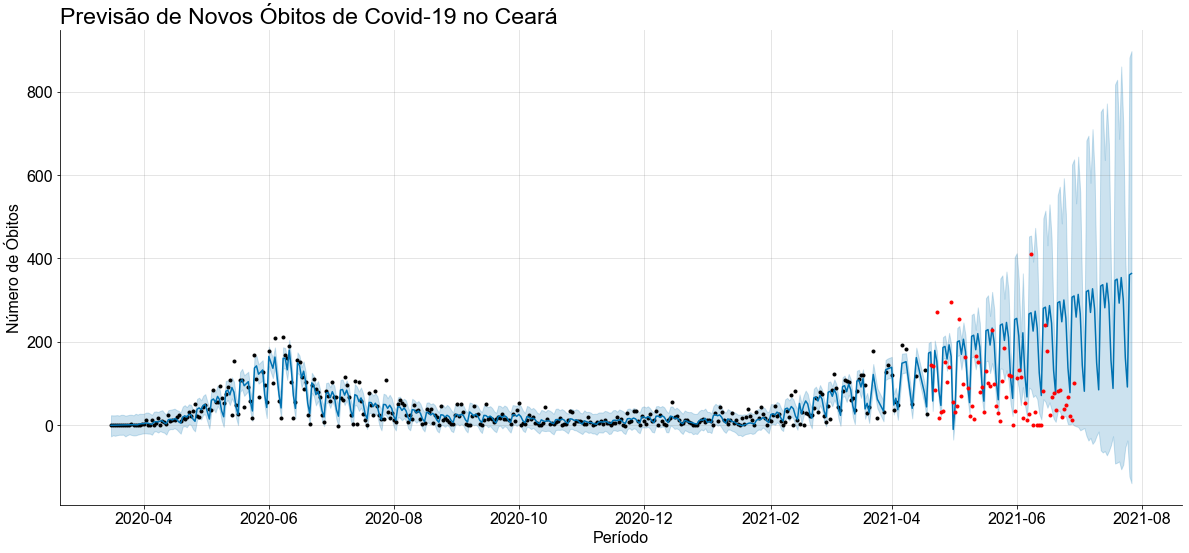

In [39]:
fig = modelo.plot(previsao, xlabel = 'Período', ylabel = 'Número de Óbitos')
plt.plot(df_teste['ds'], df_teste['y'], '.r')
ax = fig.gca()
fig.set_size_inches(18, 8)
plt.title('Previsão de Novos Óbitos de Covid-19 no Ceará', loc = 'left', fontsize = 23)
sns.despine()
plt.show()

**Análise das Componentes:**

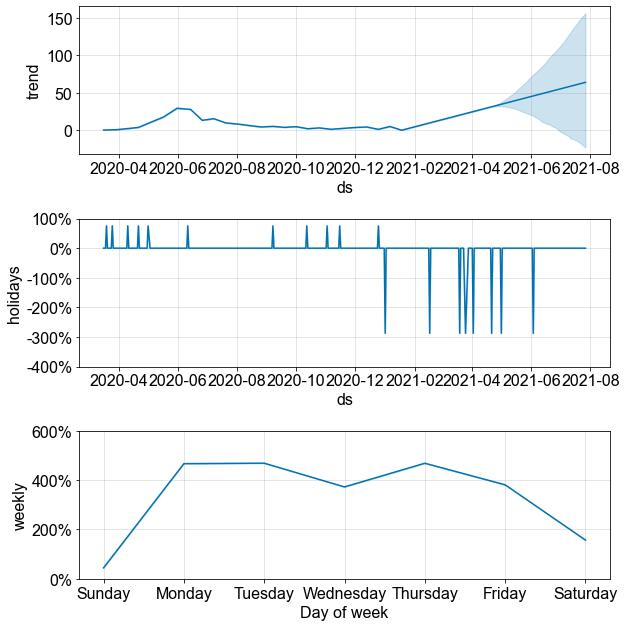

In [40]:
modelo.plot_components(previsao);

**Visualização das Possíveis Tendências de Crescimento da Série Temporal do Número de Novos Óbitos**

In [41]:
amostras = modelo.predictive_samples(previsao)

[]

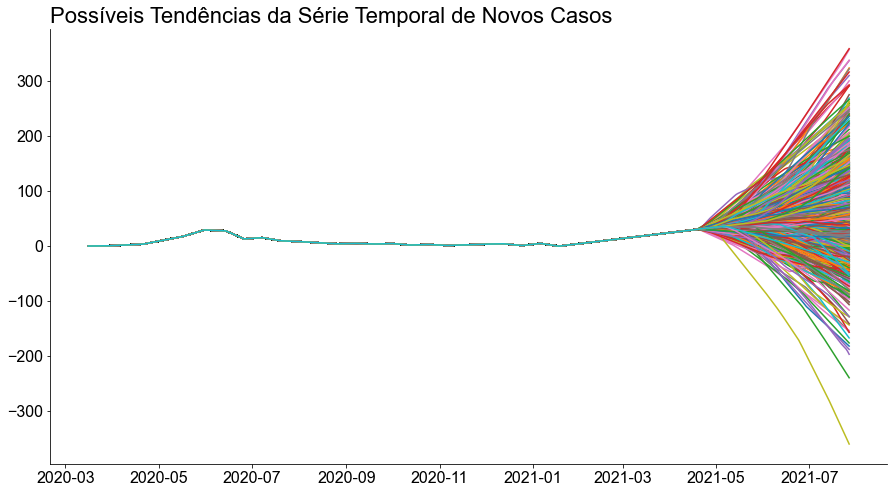

In [42]:
plt.plot(previsao['ds'], amostras['trend']);
plt.title('Possíveis Tendências da Série Temporal de Novos Casos', loc = 'left', fontsize = 22)
sns.despine()
plt.plot()

# Breve Análise da Vacinação Contra a Covid-19

Será que com os dados que já temos disponíveis sobre a vacinação contra a Covid-19 no Ceará já é possível dizer que o número de casos da doença ou o número de mortes está diminuindo? Acredito que seja cedo ainda para dizer, mas talvez já exista esperança em uma queda nos casos e nos óbitos, podende ser ou não causada pelas vacinas.

Vamos perguntar aos dados!

In [43]:
# importação do dataset já tratado
vacinas_ce = pd.read_csv('../data/vacina_total_ce.csv')

In [44]:
# breve checagem dos dados
vacinas_ce.head()

,vacina_dataaplicacao,quantidade
0,2018-02-11,1
1,2020-03-23,43896
2,2021-01-01,29
3,2021-01-04,22
4,2021-01-12,7


In [45]:
# transformando a data no formato datetime
vacinas_ce['vacina_dataaplicacao'] = pd.to_datetime(vacinas_ce['vacina_dataaplicacao'], format = '%Y-%m-%d')

In [46]:
# colocando a data como índice
vacinas_ce = vacinas_ce.set_index('vacina_dataaplicacao').rename_axis(None)

In [47]:
# excluíndo os valores antes de 2021
vacinas_ce = vacinas_ce[2:]

Vamos primeiro plotar o número de novos casos com o número de vacinas aplicadas, para ver se conseguimos extrair algum insight. Depois faremos o mesmo com o número de óbitos.

[]

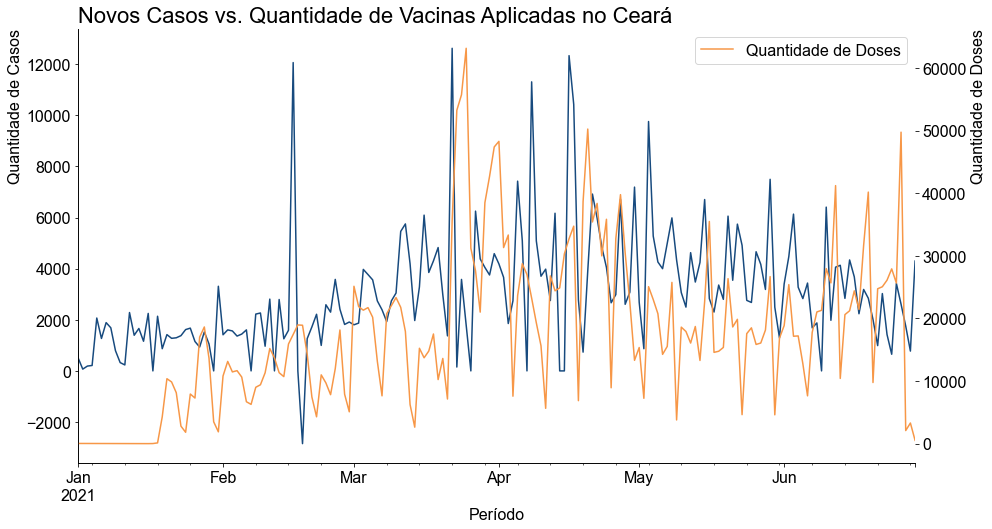

In [48]:
# plotagem do número de novos casos vs a quantidade de vacinas aplicadas
ax1 = covid_ce['novos_casos'].plot(label = 'Novos Casos', color = BLUE1)
ax2 = ax1.twinx()
ax2 = vacinas_ce['quantidade'].plot(color = ORANGE1, label = 'Quantidade de Doses')

ax1.set_title('Novos Casos vs. Quantidade de Vacinas Aplicadas no Ceará', loc = 'left', fontsize = 22)
ax1.set_ylabel('Quantidade de Casos', loc = 'top')
ax2.set_ylabel('Quantidade de Doses', loc = 'top')
ax1.set_xlabel('Período')
sns.despine()
plt.legend()
plt.plot()

[]

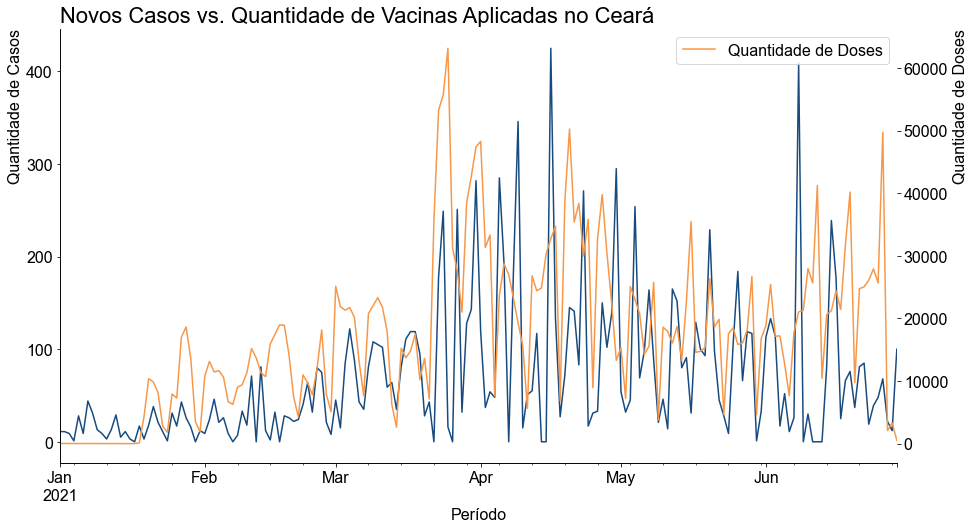

In [49]:
# plotagem do número de novos casos vs a quantidade de vacinas aplicadas
ax1 = covid_ce['novos_obitos'].plot(label = 'Novos Óbitos', color = BLUE1)
ax2 = ax1.twinx()
ax2 = vacinas_ce['quantidade'].plot(color = ORANGE1, label = 'Quantidade de Doses')

ax1.set_title('Novos Casos vs. Quantidade de Vacinas Aplicadas no Ceará', loc = 'left', fontsize = 22)
ax1.set_ylabel('Quantidade de Casos', loc = 'top')
ax2.set_ylabel('Quantidade de Doses', loc = 'top')
ax1.set_xlabel('Período')
sns.despine()
plt.legend()
plt.plot()

Podemos concluir dos dois gráficos anteriores que não existe ou não conseguimos notar uma queda no número de casos ou no número de óbitos com a quantidade de vacinas que foram aplicadas até o momento no Estado do Ceará.

Uma melhor opção seria olhar para a média móvel, que exemplifica muito melhor a tendência da série temporal. Fazemos isso a seguir.


In [50]:
# criando novas colunas no dataframe
vacinas_ce['mm_aplicacao_vacs'] = vacinas_ce['quantidade'].rolling(window = 7, center = False).mean()

[]

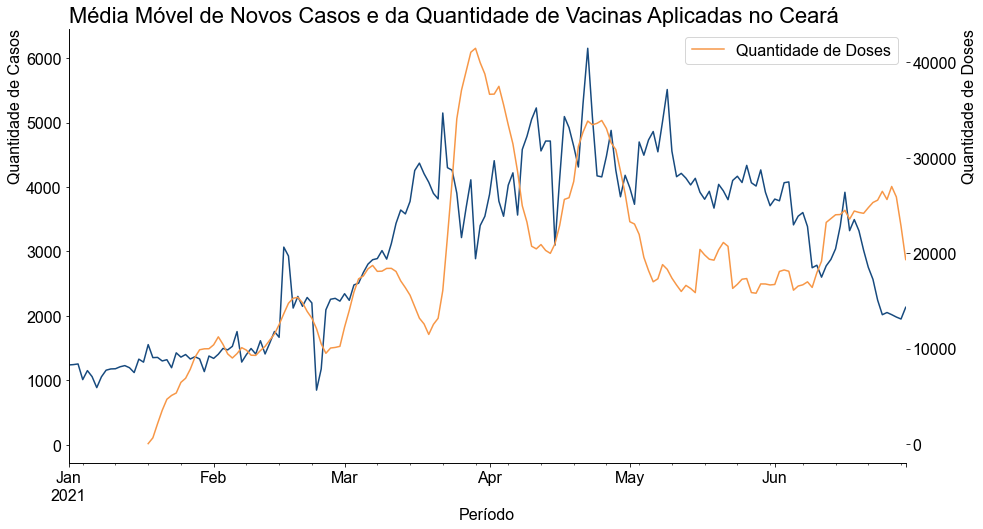

In [51]:
# plotagem da média móvel de novos casos e de vacinas aplicadas
ax1 = covid_ce['media_movel_casos'].plot(label = 'Novos Casos', color = BLUE1)
ax2 = ax1.twinx()
ax2 = vacinas_ce['mm_aplicacao_vacs'].plot(color = ORANGE1, label = 'Quantidade de Doses')

ax1.set_title('Média Móvel de Novos Casos e da Quantidade de Vacinas Aplicadas no Ceará', loc = 'left', fontsize = 22)
ax1.set_ylabel('Quantidade de Casos', loc = 'top')
ax2.set_ylabel('Quantidade de Doses', loc = 'top')
ax1.set_xlabel('Período')
sns.despine()
plt.legend()
plt.plot()

[]

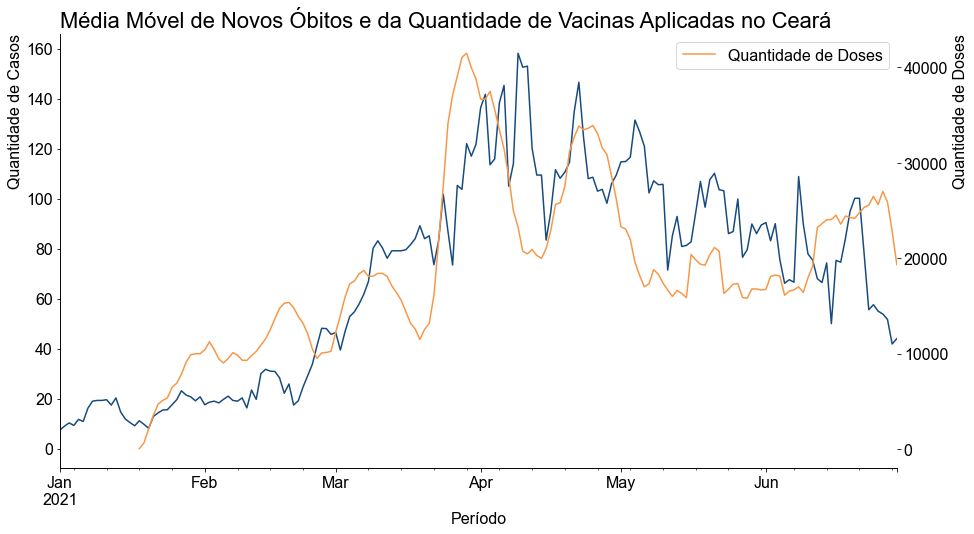

In [52]:
# plotagem da média móvel de novos óbitos e de vacinas aplicadas
ax1 = covid_ce['media_movel_obitos'].plot(label = 'Novos Óbitos', color = BLUE1)
ax2 = ax1.twinx()
ax2 = vacinas_ce['mm_aplicacao_vacs'].plot(color = ORANGE1, label = 'Quantidade de Doses')

ax1.set_title('Média Móvel de Novos Óbitos e da Quantidade de Vacinas Aplicadas no Ceará', loc = 'left', fontsize = 22)
ax1.set_ylabel('Quantidade de Casos', loc = 'top')
ax2.set_ylabel('Quantidade de Doses', loc = 'top')
ax1.set_xlabel('Período')
sns.despine()
plt.legend()
plt.plot()

Nos dois últimos gráficos, podemos notar mais claramente que há uma queda no número de novos casos e novos óbitos nos últimos dias. Mas também fica claro que é muito cedo para dizer que isso foi causado apenas pela vacina, principalmente porque a quantidade da população imunizada ainda é pouca.

Uma outra análise pode ser feita relacionando essas dados por faixa etária.

---

Por último, quero comparar a quantidade de vacinas aplicadas em homens e mulheres no Estado do Ceará, para identificar qual gênero mais se vacinou. Essa análise foi motivada por esse artigo interessantíssimo: [Why Is There Such A Gender Gap In COVID-19 Vaccination Rates?](https://fivethirtyeight.com/features/why-is-there-such-a-gender-gap-in-covid-19-vaccination-rates/). Nele algumas hipóteses são levantadas para explicar porque mulheres são mais vacinadas que homens nos Estados Unidos.

In [53]:
# importação do dataset já tratado
vac_por_sb = pd.read_csv('../data/vacina_sexo_biologico.csv')

# checagem dos dados
vac_por_sb

,paciente_enumsexobiologico,quantidade
0,F,1875667
1,I,6
2,M,1330884


**Visualização Gráfica:**

[]

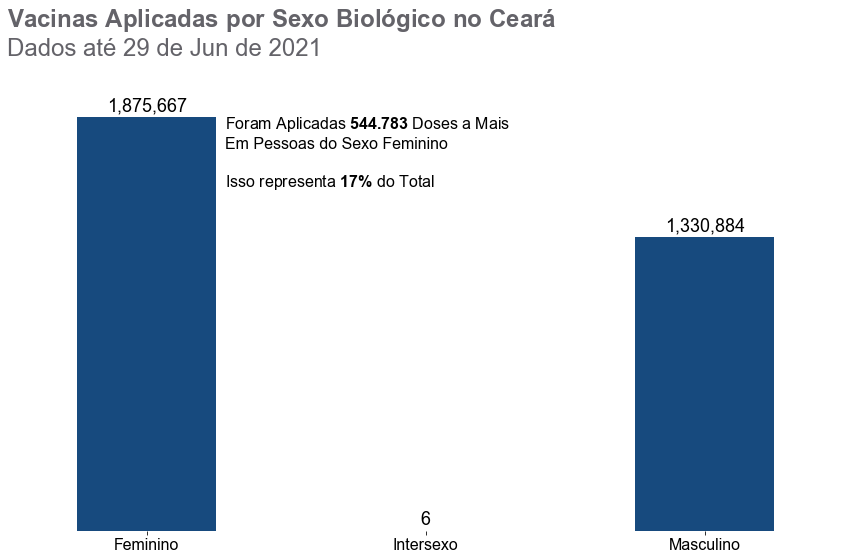

In [58]:
ax = vac_por_sb.quantidade.plot(kind = 'bar', color = BLUE1)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticklabels(['Feminino', 'Intersexo', 'Masculino'], rotation = 0)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), ',.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha = 'center', va = 'center',
                    size = 18, xytext = (0, 11),
                    textcoords = 'offset points')
    
ax.axes.get_yaxis().set_visible(False)

plt.title('$\\bf{Vacinas\ Aplicadas\ por\ Sexo\ Biológico\ no\ Ceará}$\nDados até 29 de Jun de 2021',
        fontsize = 24, loc = 'left', color = GRAY4, y = 1.08)

plt.text(0.28, 1560000, 'Foram Aplicadas $\\bf{544.783}$ Doses a Mais\nEm Pessoas do Sexo Feminino\n\nIsso representa $\\bf{17\%}$ do Total')

sns.despine(left = True, bottom = True)
plt.plot()

Isso vai de encontro ao artigo. Cito aqui as principais hipóteses para essa diferença (retiradas do artigo):

- Hipótese 1: Acesso Inicial

Como a vacinação começou por idosos, e as mulheres são a maioria dessa população, faz sentido elas serem mais imunizadas.

- Hipótese 2: Masculinidade Tradicional

Homens tendem a procurar menos os serviços de saúde, e isso se estende as vacinas.

Outras hipóteses e conclusões em: [Why Is There Such A Gender Gap In COVID-19 Vaccination Rates?](https://fivethirtyeight.com/features/why-is-there-such-a-gender-gap-in-covid-19-vaccination-rates/)

# Conclusão

Das previsões realizadas com o Prophet para o número de novos casos e para o número de novos óbitos no Estado do Ceará, vemos que os números não parecem estar diminuindo, o que não é uma boa notícia para todos.

Sobre a vacinação, ainda é cedo para podermos afirmar que certa diminuição nos números são causa direta da vacinação, pois ela ainda está caminhando lentamente.

Por último, vimos que foram vacinadas mais de 500.000 mulheres a mais que homens no Estado do Ceará.

# Proposta de Melhorias

- Melhorar os hiperparâmetros do Prophet para uma melhor previsão.
- Escalar os dados para usar o método ```".add_regressor()"``` do Prophet.
- Levar a análise para novos dados, como a taxa de mortalidade, por exemplo.
- Dividir a análise da vacinação por faixa etária.

# Referências

- [Secretaria de Saúde do Estado do Ceará](https://www.saude.ce.gov.br/)
- [Sesa busca propostas de ferramentas para prever curva da Covid-19](https://diariodonordeste.verdesmares.com.br/metro/sesa-busca-propostas-de-ferramentas-para-prever-curva-da-covid-19-1.3009707)
- [IntegraSUS Analytics](https://integrasusanalytics.saude.ce.gov.br/pt/home)
- [Secretaria da Saúde do Ceará lança plataforma de dados IntegraSUS Analytics](http://www.issec.ce.gov.br/index.php/assessoria-de-comunicacao/listanoticias/932-secretaria-da-saude-do-ceara-lanca-plataforma-de-dados-integrasus-analytics)
- [Brasil.io](https://brasil.io/home/)
- [Covid-19 - Brasil.io](https://brasil.io/dataset/covid19/caso_full/)
- [OpenDataSUS: Registros de Vacinação COVID-19](https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao/resource/ef3bd0b8-b605-474b-9ae5-c97390c197a8)
- [Why Is There Such A Gender Gap In COVID-19 Vaccination Rates?](https://fivethirtyeight.com/features/why-is-there-such-a-gender-gap-in-covid-19-vaccination-rates/)